In [1]:
%matplotlib inline

# import packages
import numpy as np
import time
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
from matplotlib import gridspec

import torch
from torch.nn import Linear, LeakyReLU, MSELoss, Sequential
from torch.optim import Adam

from kymatio import Scattering1D


In [2]:
# define plot properties
from cycler import cycler
import matplotlib.cm as cm

from matplotlib import rcParams
from matplotlib import rc
from mpl_toolkits.axes_grid1 import make_axes_locatable

def rgb(r,g,b):
    return (float(r)/256.,float(g)/256.,float(b)/256.)

cb2 = [rgb(31,120,180), rgb(255,127,0), rgb(51,160,44), rgb(227,26,28), \
       rgb(166,206,227), rgb(253,191,111), rgb(178,223,138), rgb(251,154,153)]

rcParams['figure.figsize'] = (9,7.5)
#rcParams['figure.dpi'] = 300

rcParams['lines.linewidth'] = 1

rcParams['axes.prop_cycle'] = cycler('color', cb2)
rcParams['axes.facecolor'] = 'white'
rcParams['axes.grid'] = False

rcParams['patch.facecolor'] = cb2[0]
rcParams['patch.edgecolor'] = 'white'

rcParams['font.size'] = 23


## Analytic power spectrum 

> Make CAR(1) models.

In [9]:
# duration
duration = 100

# define time array
t_clean = np.linspace(0, duration=0.1, int(duration*100.))

#------------------------------------------------------------------------------------
### make the first component ###
# choosing the mean from Kelley+ 09
# tau_1 = 10**(2.75-0.66)
# sigma_1 = 10**(-2.04-0.23)
tau_1 = 10**(2.75)
sigma_1 = 10**(-2.04)

# the mean scale 
c_mag_1 = 17.

# generate CAR1 covariance matrix
r = np.fabs(t_clean[:,None] - t_clean[None,:])
var = 0.5*tau_1*sigma_1**2
cov = var*np.exp(-r/tau_1)

# generate light curve
n = len(t_clean)
c_mag = c_mag_1*np.ones((n,)) # mean magnitude
y_clean_1 = np.random.multivariate_normal(c_mag,cov)
   
#------------------------------------------------------------------------------------
### make the first component ###
# choosing the mean from Kelley+ 09
# tau_2 = 10**(2.75+0.66)
# sigma_2 = 10**(-2.04+0.23)
# tau_2 = 10**(2.75)
# sigma_2 = 10**(-2.04)

# # the mean scale 
# c_mag_2 = 17.

# # generate CAR1 covariance matrix
# r = np.fabs(t_clean[:,None] - t_clean[None,:])
# var = 0.5*tau_2*sigma_2**2
# cov = var*np.exp(-r/tau_2)

# # generate light curve
# n = len(t_clean)
# c_mag = c_mag_2*np.ones((n,)) # mean magnitude
# y_clean_2 = np.random.multivariate_normal(c_mag,cov)


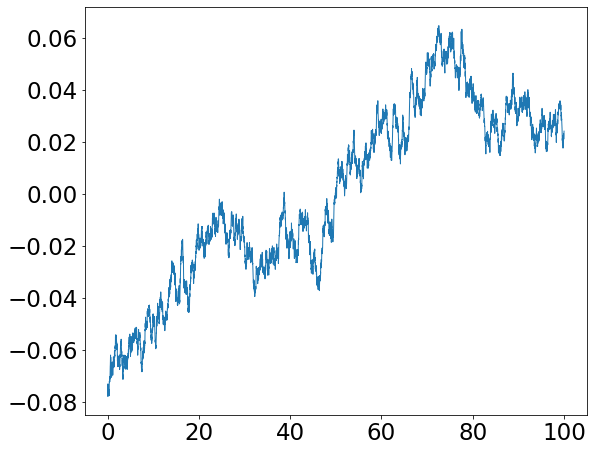

In [10]:
# plot light curve
plt.plot(t_clean,y_clean_1-y_clean_1.mean())
# plt.plot(t_clean,y_clean_2-y_clean_2.mean())
# plt.plot(t_clean,y_clean_1-y_clean_1.mean()+y_clean_2-y_clean_2.mean())


> Evaluate the power spectrum.

Text(0.5, 0, 'frequency (1/day)')

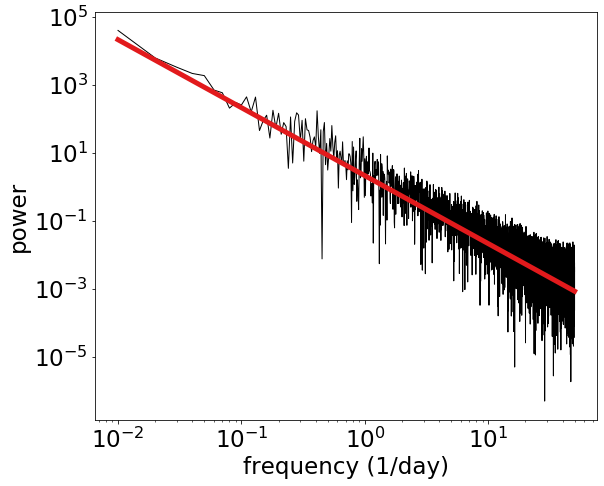

In [11]:
from scipy.fftpack import fft, rfft, fftfreq

# frequency array
W = fftfreq(y_clean_1.size, d=(t_clean[1]-t_clean[0]))
fTrue = np.logspace(np.log10(min(W[W>0])), np.log10(max(W[W>0])))


#=========================================================================================
### first component ###
f_signal = fft(y_clean_1)

# plot power spectrum
plt.plot(W[W>0], np.absolute(f_signal[W>0])**2, color="k")

# #------------------------------------------------------------------------------------------
# ### second component ###
# y_clean = y_clean_2 - y_clean_2.mean() 
# f_signal = fft(y_clean)

# # plot power spectrum
# plt.plot(W[W>0], np.absolute(f_signal[W>0])**2, color="k")

# #------------------------------------------------------------------------------------------
# ### mixed component ###
# y_clean = (y_clean_1 + y_clean_2)
# f_signal = fft(y_clean)

# # # plot power spectrum
# plt.plot(W[W>0], np.absolute(f_signal[W>0])**2, color="k")


#=========================================================================================
# theoretical power spectrum
pTrue = (n/t_clean[1]-t_clean[0])*(sigma_1**2*tau_1**2/(1 + (2*np.pi*tau_1*fTrue)**2))
plt.plot(fTrue, pTrue, label="truth", color=cb2[3], lw=5)

# pTrue = (n/t_clean[1]-t_clean[0])*sigma_2**2*tau_2**2/(1 + (2*np.pi*tau_2*fTrue)**2)
# plt.plot(fTrue,pTrue, label="truth", color=cb2[2], lw=5)

# pTrue = (n/t_clean[1]-t_clean[0])*((sigma_1**2*tau_1**2/(1 + (2*np.pi*tau_1*fTrue)**2)) \
#             + (sigma_2**2*tau_2**2/(1 + (2*np.pi*tau_2*fTrue)**2)))
# plt.plot(fTrue, pTrue, label="truth", color=cb2[0], lw=5)


#=========================================================================================
# plot properties
plt.xscale("log")
plt.yscale("log")
plt.ylabel("power")
plt.xlabel("frequency (1/day)")


> Make model in flux.

In [ ]:
# duration
duration = 1000

# define time array
t_clean = np.linspace(0, duration, int(duration))

#------------------------------------------------------------------------------------
### make the first component ###
# choosing the mean from Kelley+ 09
# tau_1 = 10**(2.75-0.66)
# sigma_1 = 10**(-2.04-0.23)
tau_1 = 10**(2.75)
sigma_1 = 10**(-2.04)

# the mean scale 
c_mag_1 = 17.

# generate CAR1 covariance matrix
r = np.fabs(t_clean[:,None] - t_clean[None,:])
var = 0.5*tau_1*sigma_1**2
cov = var*np.exp(-r/tau_1)

# generate light curve
n = len(t_clean)
c_mag = c_mag_1*np.ones((n,)) # mean magnitude
y_clean_1 = np.random.multivariate_normal(c_mag,cov)
   
y_clean_1 = 10**((18-y_clean_1)/2.5)
# f2 = 10**((18-m2)/2.5)
# f = f1 + f2
# y = 18-2.5*np.log10(f)

#------------------------------------------------------------------------------------
# plot light curve
plt.plot(t_clean,y_clean_1)

## Wavelet Scattering Representation.

> Extract kymatio filters.

In [ ]:
from kymatio.scattering1d.filter_bank import scattering_filter_factory
T = 2**13
J = 7
Q = 1

phi_f, psi1_f, psi2_f, _ = scattering_filter_factory(np.log2(T), J, Q)

plt.figure()
plt.plot(np.arange(T)/10.,phi_f[0], 'r')

for psi_f in psi1_f:
    plt.plot(np.arange(T)/10.,psi_f[0], 'b')

plt.xlim(0, 800.)

plt.xlabel(r'$\omega$', fontsize=18)
plt.ylabel(r'$\hat\psi_j(\omega)$', fontsize=18)
plt.title('First-order filters (Q = {})'.format(Q), fontsize=18)


In [ ]:
from scipy import interpolate

# original step size
x_conv = -np.arange(psi1_f[0][0].shape[0]) + psi1_f[0][0].shape[0]/2.

# interpolate into a regular grid of 0.1 day
t_conv = np.linspace(-4000,4000,8001)

#--------------------------------------------------------------------------------------
# make the convolution
kernel = []

# extract kernel and interpolation to the same grid
for i in range(len(psi1_f)):
    kernel_temp = np.fft.fftshift(np.fft.ifft(np.fft.ifftshift(psi1_f[i][0])))
    f_power = interpolate.interp1d(x_conv, kernel_temp)
    kernel.append(f_power(t_conv))

# convert into numpy array
kernel = np.array(kernel)

#--------------------------------------------------------------------------------------
# plot kernel
plt.plot(t_conv, np.real(kernel[-1]),lw=1, label="real part")
plt.plot(t_conv, np.imag(kernel[-1]),lw=1, label="complex part")
plt.plot(t_conv, np.absolute(kernel[-1]), lw=5, label="modulus", color="k")
plt.legend()
#plt.xlim([3000,5000])

In [ ]:
print(len(kernel))

In [ ]:
# save kernel
np.save("kernel_wavelet.npy", kernel)

> Perform convolution.

In [ ]:
# load kernel
kernel = np.load("kernel_wavelet.npy")

# choose a kernel 
kernel_choose = kernel[0]


#====================================================================================
# choose a ZTF time step
temp = np.load("../SDSS_DR14_qso_mock_normal_sparse.npz", allow_pickle=True)
ztf_time = temp["t_array"]
ztf_time = temp["t_array"][164]
choose_step = np.unique((ztf_time*10).astype("int"))

# plot the original light curve
temp = np.load("../SDSS_DR14_qso_mock_normal_dense.npz")
t_array = temp["t_array"][100]
real_spec = temp["light_curve"][100]
real_spec = np.array([complex(real_spec[i]) for i in range(real_spec.size)])

#-----------------------------------------------------------------------------------------------
# subsample with ZTF time step
real_spec = real_spec[choose_step]
time_stamp = t_array[choose_step]

# interpolate fascilitate convolution
f_power = interpolate.interp1d(choose_step, real_spec, kind='nearest',\
                               bounds_error=False, fill_value=(real_spec[0],real_spec[-1]))
real_spec = f_power(np.arange(10000))
    
# plot real curve
#plt.plot(real_spec, label="Light Curve 1")

#-------------------------------------------------------------------------------------
# zero order coefficient
real_spec_smooth = np.zeros(real_spec.size)
real_spec_smooth = real_spec_smooth.astype("complex")

# convolve with kernel
for i in range(real_spec.size):
    real_spec_truncate = real_spec[np.max([0,i-4000]):i+4000+1]
    real_spec_smooth[i] = np.sum(real_spec_truncate*kernel[0][np.max([0,4000-i]):][:real_spec_truncate.size])  

Sx0 = np.median(np.absolute(real_spec_smooth))


#-------------------------------------------------------------------------------------
# iniatite array
real_spec_smooth = np.zeros(real_spec.size)
real_spec_smooth = real_spec_smooth.astype("complex")

# convolve with kernel
for i in range(real_spec.size):
    real_spec_truncate = real_spec[np.max([0,i-4000]):i+4000+1]
    real_spec_smooth[i] = np.sum(real_spec_truncate*kernel_choose[np.max([0,4000-i]):][:real_spec_truncate.size])
    
light_curve_extract = np.absolute(real_spec_smooth)/Sx0
plt.plot(light_curve_extract, alpha=0.5, color=cb2[4])
#plt.plot([0,10000], [np.median(light_curve_extract),np.median(light_curve_extract)], color=cb2[0], lw=5)

plt.scatter(np.arange(10000)[choose_step], light_curve_extract[choose_step], alpha=0.5, color=cb2[4])


#====================================================================================
# # plot the original light curve
# temp = np.load("../SDSS_DR14_qso_mock_normal_dense.npz")
# real_spec = temp["light_curve"][300]
# real_spec = np.array([complex(real_spec[i]) for i in range(real_spec.size)])

# # plot real curve
# #plt.plot(real_spec, label="Light Curve 1")

# #-------------------------------------------------------------------------------------
# # zero order coefficient
# real_spec_smooth = np.zeros(real_spec.size)
# real_spec_smooth = real_spec_smooth.astype("complex")

# # convolve with kernel
# for i in range(real_spec.size):
#     real_spec_truncate = real_spec[np.max([0,i-4000]):i+4000+1]
#     real_spec_smooth[i] = np.sum(real_spec_truncate*kernel[0][np.max([0,4000-i]):][:real_spec_truncate.size])
    
# Sx0 = np.median(np.absolute(real_spec_smooth))


# #-------------------------------------------------------------------------------------
# # iniatite array
# real_spec_smooth = np.zeros(real_spec.size)
# real_spec_smooth = real_spec_smooth.astype("complex")

# # convolve with kernel
# for i in range(real_spec.size):
#     real_spec_truncate = real_spec[np.max([0,i-4000]):i+4000+1]
#     real_spec_smooth[i] = np.sum(real_spec_truncate*kernel_choose[np.max([0,4000-i]):][:real_spec_truncate.size])
    
# light_curve_extract = np.absolute(real_spec_smooth[100:-100])/Sx0
# plt.plot(light_curve_extract, alpha=0.5, color=cb2[5])
# plt.plot([0,10000], [np.median(light_curve_extract),np.median(light_curve_extract)], color=cb2[1], lw=5)


# #====================================================================================
# # plot the original light curve
# temp = np.load("../SDSS_DR14_qso_mock_normal_dense.npz")
# real_spec = (temp["light_curve"][300] + temp["light_curve"][100])/2.
# real_spec = np.array([complex(real_spec[i]) for i in range(real_spec.size)])

# # plot real curve
# #plt.plot(real_spec, label="Light Curve 1")

# #-------------------------------------------------------------------------------------
# # zero order coefficient
# real_spec_smooth = np.zeros(real_spec.size)
# real_spec_smooth = real_spec_smooth.astype("complex")

# # convolve with kernel
# for i in range(real_spec.size):
#     real_spec_truncate = real_spec[np.max([0,i-4000]):i+4000+1]
#     real_spec_smooth[i] = np.sum(real_spec_truncate*kernel[0][np.max([0,4000-i]):][:real_spec_truncate.size])
    
# Sx0 = np.median(np.absolute(real_spec_smooth))


# #-------------------------------------------------------------------------------------
# # iniatite array
# real_spec_smooth = np.zeros(real_spec.size)
# real_spec_smooth = real_spec_smooth.astype("complex")

# # convolve with kernel
# for i in range(real_spec.size):
#     real_spec_truncate = real_spec[np.max([0,i-4000]):i+4000+1]
#     real_spec_smooth[i] = np.sum(real_spec_truncate*kernel_choose[np.max([0,4000-i]):][:real_spec_truncate.size])
    
# light_curve_extract = np.absolute(real_spec_smooth[100:-100])/Sx0
# plt.plot(light_curve_extract, alpha=0.5, color=cb2[6])
# plt.plot([0,10000], [np.median(light_curve_extract),np.median(light_curve_extract)], color=cb2[2], lw=5)


#====================================================================================
plt.legend()
plt.ylabel("Power")
plt.xlabel("Time")

plt.xlim([400,600])
plt.ylim([1.05,1.1])
#plt.ylim([-0.001,0.01])

In [ ]:
#====================================================================================
# choose a ZTF time step
temp = np.load("../SDSS_DR14_qso_mock_normal_sparse.npz", allow_pickle=True)
ztf_time = temp["t_array"]
ztf_time = temp["t_array"][164]
choose_step = np.unique((ztf_time*10).astype("int"))

# plot the original light curve
temp = np.load("../SDSS_DR14_qso_mock_normal_dense.npz")
t_array = temp["t_array"][100]
real_spec = temp["light_curve"][100]
real_spec = np.array([complex(real_spec[i]) for i in range(real_spec.size)])

#-----------------------------------------------------------------------------------------------
# subsample with ZTF time step
real_spec = real_spec[choose_step]
time_stamp = t_array[choose_step]

plt.scatter(choose_step, real_spec)

f_power = interpolate.interp1d(choose_step, real_spec, kind='nearest',\
                               bounds_error=False, fill_value=(real_spec[0],real_spec[-1]))
real_spec = f_power(np.arange(10000))
plt.plot(np.arange(10000), real_spec)

plt.xlim([800,1000])
plt.ylim([7.9, 8.5])

> Calculate scattering coefficients.

In [ ]:
# import packages
from kymatio import Scattering1D
import kymatio

import torch.nn as nn
import torch.optim
import torch
import torch.utils.data as utils

import time
import sys

import numpy as np


#=========================================================================================================
# load light curves
real_spec = np.load("../light_curve.npy")[:10,:]
print(real_spec.shape)

### change the amplitude
#real_spec = real_spec*2.

## mix two modes
#real_spec = (real_spec[:,:] + real_spec[::-1,:])/2.


#================================================================================================
# define wavelet scattering hyperparameters
J = 6
Q = 8
T = real_spec.shape[1]

# convert into torch variable
x = torch.from_numpy(real_spec[:,:T]).type(torch.FloatTensor)
print(x.shape)

# define wavelet scattering
scattering = Scattering1D(J, T, Q)

#================================================================================================
# perform wavelet scattering
Sx_all = scattering.forward(x)

# calculate invariate representation
Sx_all = torch.mean(Sx_all, dim=-1)

# normalize wrt to the first coefficient
for i in range(Sx_all.shape[0]):
    Sx_all[i,:] = Sx_all[i,:]/np.abs(Sx_all[i,0])
    
# take log to normalize the coefficient better
Sx_all = torch.log10(Sx_all[:,1:])
print(Sx_all.shape)

In [ ]:
Sx_all_1 = np.copy(Sx_all)

In [ ]:
Sx_all = Sx_all.numpy()

In [ ]:
print(Sx_all_1[0,:])
plt.plot(Sx_all_1[0,:])
plt.plot(Sx_all[0,:])

> Check wavelet scattering coefficients.

In [ ]:
# load scattering coefficients
Sx = np.load("../Sx_all.npy")
plt.hist(Sx.ravel(), bins=100);

> Visualize first order WST coefficients as a proxy for power spectrum.

In [ ]:
# import packages
import numpy as np
from astropy.io import fits
import os

import torch
from torch import nn
from torch import distributions
from torch.nn.parameter import Parameter
from torch.autograd import Variable

os.environ['KMP_DUPLICATE_LIB_OK']='True'


#=======================================================================================================
# In [2]:
# define normalizing flow
class RealNVP(nn.Module):
    def __init__(self, nets, nett, mask, prior):
        super(RealNVP, self).__init__()

        self.prior = prior
        self.mask = nn.Parameter(mask, requires_grad=False)
        self.t = torch.nn.ModuleList([nett() for _ in range(len(masks))])
        self.s = torch.nn.ModuleList([nets() for _ in range(len(masks))])

    def g(self, z):
        x = z
        for i in range(len(self.t)):
            x_ = x*self.mask[i]
            s = self.s[i](x_)*(1 - self.mask[i])
            t = self.t[i](x_)*(1 - self.mask[i])
            x = x_ + (1 - self.mask[i]) * (x * torch.exp(s) + t)
        return x

    def f(self, x):
        log_det_J, z = x.new_zeros(x.shape[0]), x
        for i in reversed(range(len(self.t))):
            z_ = self.mask[i] * z
            s = self.s[i](z_) * (1-self.mask[i])
            t = self.t[i](z_) * (1-self.mask[i])
            z = (1 - self.mask[i]) * (z - t) * torch.exp(-s) + z_
            log_det_J -= s.sum(dim=1)
        return z, log_det_J

    def log_prob(self,x):
        z, logp = self.f(x)
        return self.prior.log_prob(z) + logp

    def sample(self, z):
        x = self.g(z)
        return x
    
    
#==================================================================================
# restore models
flow = torch.load("../flow_final_dense.pt", map_location=lambda storage, loc: storage) # load in cpu
flow.eval()


In [ ]:
Sx_coefficient = np.load("../Sx_all_mixed_dense.npy").T
plt.plot(np.log10(Sx_coefficient), color=cb2[0], alpha=0.1);
plt.plot(np.log10(Sx_coefficient[:,0]), color=cb2[0], label="mixed");

Sx_coefficient = np.load("../Sx_all_normal_dense.npy").T
plt.plot(np.log10(Sx_coefficient), color=cb2[1], alpha=0.1);
plt.plot(np.log10(Sx_coefficient[:,0]), color=cb2[1], label="normal");

# flow_sample = flow.sample(torch.from_numpy(np.random.normal(size=(10000,7))).float()).detach().numpy().T
# plt.plot(flow_sample, color=cb2[1], alpha=0.1);
# plt.plot(flow_sample[:,0], color=cb2[1], label="Normalizing flow sample");

# plt.xticks(np.arange(7),['100d','30d','10d','3d','1d','0.3d','0.1d'])
plt.legend()
plt.xlabel("Scale")
plt.ylabel("Coefficients")


In [ ]:
# choose a index
ind = 6

y_tr = np.load("../Sx_all_normal_dense.npy")
y_tr = np.log10(y_tr)
plt.hist(y_tr[:,ind], bins=50, range=[-6,-2], alpha=0.5);

y_tr = np.load("../Sx_all_mixed_dense.npy")
y_tr = np.log10(y_tr)
plt.hist(y_tr[:,ind], bins=50, range=[-6,-2], alpha=0.5);

flow_sample = flow.sample(torch.from_numpy(np.random.normal(size=(1000,7))).float()).detach().numpy()
plt.hist(flow_sample[:,ind], color=cb2[2], bins=50, alpha=0.5, range=[-6,-2])


> Reduce to power law indices.

In [ ]:
from scipy import stats
import numpy as np

#-----------------------------------------------------------------------------------------------------------
# make linear regression
slope_1 = []
intercept_1 = []
Sx_coefficient = np.load("../Sx_all_mixed_dense.npy")[:,:4]
Sx_coefficient = np.log10(Sx_coefficient)
for i in range(Sx_coefficient.shape[0]):
    slope, intercept, dummy, dummy, dummy = stats.linregress(np.arange(Sx_coefficient.shape[1]),Sx_coefficient[i,:])
    slope_1.append(slope)
    intercept_1.append(intercept)
slope_1 = np.array(slope_1)
intercept_1 = np.array(intercept_1)

#-----------------------------------------------------------------------------------------------------------
# make linear regression
slope_2 = []
intercept_2 = []
Sx_coefficient = np.load("../Sx_all_normal_dense.npy")[:,:4]
Sx_coefficient = np.log10(Sx_coefficient)

for i in range(Sx_coefficient.shape[0]):
    slope, intercept, dummy, dummy, dummy = stats.linregress(np.arange(Sx_coefficient.shape[1]),Sx_coefficient[i,:])
    slope_2.append(slope)
    intercept_2.append(intercept)
slope_2 = np.array(slope_2)
intercept_2 = np.array(intercept_2)


#-----------------------------------------------------------------------------------------------------------
# plot results
# plt.hist(slope_1, bins=50, alpha=0.5)
# plt.hist(slope_2, bins=50, alpha=0.5)

plt.hist(intercept_1, bins=50, alpha=0.5)
plt.hist(intercept_2, bins=50, alpha=0.5)
plt.xlabel("'Power Law' Intercept")
plt.ylabel("Histogram")

> Investigate first scattering order coefficient.

In [ ]:
# plot the original light curve
temp = np.load("../SDSS_DR14_qso_mock_normal_dense.npz")
real_spec = temp["light_curve"][100]
real_spec_2 = temp["light_curve"][300]
mixed_spec = (temp["light_curve"][100] + temp["light_curve"][300])/2.

# substract the mean
real_spec = real_spec - np.mean(real_spec)
real_spec_2 = real_spec_2 - np.mean(real_spec_2)
mixed_spec = mixed_spec - np.mean(mixed_spec)

plt.plot(real_spec, label="Light Curve 1")
plt.plot(real_spec_2, label="Light Curve 2")
plt.plot(mixed_spec, label="Average light curve")

plt.legend()
plt.ylabel("Flux")
plt.xlabel("Time")

In [ ]:
# make the fourier transform
sp = np.fft.fft(real_spec)
freq = np.fft.fftfreq(real_spec.shape[-1])

# make frequency filtering
choose = (np.abs(freq) > 0.02)*(np.abs(freq) < 0.04) == 0.
sp[choose] = 0.

plt.plot(freq, sp.real, freq, sp.imag)
plt.ylim([-100,100])

# make inverse transform
real_spec_i = np.fft.ifft(sp)


#==========================================================================
# make the fourier transform
sp = np.fft.fft(real_spec_2)
freq = np.fft.fftfreq(real_spec_2.shape[-1])

# make frequency filtering
choose = (np.abs(freq) > 0.02)*(np.abs(freq) < 0.04) == 0.
sp[choose] = 0.

# make inverse transform
real_spec_2_i = np.fft.ifft(sp)


#==========================================================================
# make the fourier transform
sp = np.fft.fft(mixed_spec)
freq = np.fft.fftfreq(mixed_spec.shape[-1])

# make frequency filtering
choose = (np.abs(freq) > 0.02)*(np.abs(freq) < 0.04) == 0.
sp[choose] = 0.

# make inverse transform
mixed_spec_i = np.fft.ifft(sp)


> Comparing the orignal light curve with the filtered version.

In [ ]:
plt.plot(real_spec_i, label="Light Curve 1")
plt.plot(real_spec_2_i, label="Light Curve 2")
plt.plot(mixed_spec_i, label="Average light curve")

plt.legend()
plt.ylabel("Flux")
plt.xlabel("Time")

> Check number of time steps.

In [ ]:
# choose a ZTF time step
temp = np.load("../SDSS_DR14_qso_mock_normal_sparse.npz", allow_pickle=True)
ztf_time = temp["t_array"]
time_length = np.array([ztf_time[i].size for i in range(ztf_time.size)])

plt.hist(time_length)
print(np.min(time_length))
print(np.argmin(time_length))

> Define analytically top hat method that can deal with irregular sampling.

In [ ]:
# choose a ZTF time step
temp = np.load("../SDSS_DR14_qso_mock_normal_sparse.npz", allow_pickle=True)
ztf_time = temp["t_array"][133]
ztf_time = np.unique((ztf_time*10).astype("int"))
print(ztf_time.shape)

# plot the original light curve
temp = np.load("../SDSS_DR14_qso_mock_normal_dense.npz")
time_stamp = temp["t_array"][100,ztf_time]
real_spec = temp["light_curve"][100][ztf_time]
real_spec_2 = temp["light_curve"][300][ztf_time]
mixed_spec = (temp["light_curve"][100][ztf_time] + temp["light_curve"][300][ztf_time])/2.

# substract the mean
real_spec = real_spec - np.mean(real_spec)
real_spec_2 = real_spec_2 - np.mean(real_spec_2)
mixed_spec = mixed_spec - np.mean(mixed_spec)

# smooth the data
plt.plot(time_stamp, real_spec, label="Light Curve 1")
plt.plot(time_stamp, real_spec_2, label="Light Curve 2")
plt.plot(time_stamp, mixed_spec, label="Average light curve")
plt.scatter(time_stamp, mixed_spec, s=30, color="black")

plt.legend()
plt.ylabel("Flux")
plt.xlabel("Time [day]")


In [ ]:
# choose a ZTF time step
temp = np.load("../SDSS_DR14_qso_mock_normal_sparse.npz", allow_pickle=True)
ztf_time = temp["t_array"][133]
ztf_time = np.unique((ztf_time*10).astype("int"))

# plot the original light curve
temp = np.load("../SDSS_DR14_qso_mock_normal_dense.npz")
time_stamp = temp["t_array"][100,ztf_time]
real_spec = temp["light_curve"][100][ztf_time]
real_spec_2 = temp["light_curve"][300][ztf_time]
mixed_spec = (temp["light_curve"][100][ztf_time] + temp["light_curve"][300][ztf_time])/2.

# substract the mean
real_spec = real_spec - np.mean(real_spec)
real_spec_2 = real_spec_2 - np.mean(real_spec_2)
mixed_spec = mixed_spec - np.mean(mixed_spec)

#----------------------------------------------------------------------------------------------------
# choose windows of convolution (in unit of days)
window_array = 10.**np.linspace(-1,2,7)[::-1]


#====================================================================================================
# make smooth template
real_spec_smooth = np.copy(real_spec)
real_spec_2_smooth = np.copy(real_spec_2)
mixed_spec_smooth = np.copy(mixed_spec)

# loop over all pixels
for i in range(real_spec.size):    

    choose = np.abs(time_stamp - time_stamp[i]) < window_array[0]
    real_spec_smooth[i] = np.mean(real_spec[choose])
    real_spec_2_smooth[i] = np.mean(real_spec_2[choose])
    mixed_spec_smooth[i] = np.mean(mixed_spec[choose])

# substract away this frequency scale
real_spec = real_spec - real_spec_smooth
real_spec_2 = real_spec_2 - real_spec_2_smooth
mixed_spec = mixed_spec - mixed_spec_smooth

#----------------------------------------------------------------------------------------------------
# plot the smooth function
plt.figure()
plt.plot(real_spec, label="Light Curve 1")
plt.plot(real_spec_2, label="Light Curve 2")
plt.plot(mixed_spec, label="Average light curve")


#====================================================================================================
# make smooth template
real_spec_smooth = np.copy(real_spec)
real_spec_2_smooth = np.copy(real_spec_2)
mixed_spec_smooth = np.copy(mixed_spec)

# loop over all pixels
for i in range(real_spec.size):    

    choose = np.abs(time_stamp - time_stamp[i]) < window_array[1]
    real_spec_smooth[i] = np.mean(real_spec[choose])
    real_spec_2_smooth[i] = np.mean(real_spec_2[choose])
    mixed_spec_smooth[i] = np.mean(mixed_spec[choose])

# substract away this frequency scale
real_spec = real_spec - real_spec_smooth
real_spec_2 = real_spec_2 - real_spec_2_smooth
mixed_spec = mixed_spec - mixed_spec_smooth

#----------------------------------------------------------------------------------------------------
# plot the smooth function
plt.figure()
plt.plot(real_spec, label="Light Curve 1")
plt.plot(real_spec_2, label="Light Curve 2")
plt.plot(mixed_spec, label="Average light curve")


#====================================================================================================
# make smooth template
real_spec_smooth = np.copy(real_spec)
real_spec_2_smooth = np.copy(real_spec_2)
mixed_spec_smooth = np.copy(mixed_spec)

# loop over all pixels
for i in range(real_spec.size):    

    choose = np.abs(time_stamp - time_stamp[i]) < window_array[2]
    real_spec_smooth[i] = np.mean(real_spec[choose])
    real_spec_2_smooth[i] = np.mean(real_spec_2[choose])
    mixed_spec_smooth[i] = np.mean(mixed_spec[choose])

# substract away this frequency scale
real_spec = real_spec - real_spec_smooth
real_spec_2 = real_spec_2 - real_spec_2_smooth
mixed_spec = mixed_spec - mixed_spec_smooth

#----------------------------------------------------------------------------------------------------
# plot the smooth function
plt.figure()
plt.plot(real_spec, label="Light Curve 1")
plt.plot(real_spec_2, label="Light Curve 2")
plt.plot(mixed_spec, label="Average light curve")


>  Similar but using wavelet.

In [ ]:
from scipy import interpolate

# choose a ZTF time step
temp = np.load("../SDSS_DR14_qso_mock_normal_sparse.npz", allow_pickle=True)
ztf_time = temp["t_array"][133]
ztf_time = np.unique((ztf_time*10).astype("int"))

# plot the original light curve
temp = np.load("../SDSS_DR14_qso_mock_normal_dense.npz")
time_stamp = temp["t_array"][100,ztf_time]
real_spec = temp["light_curve"][100][ztf_time]

#------------------------------------------------------------------------------------
# interpolate with nearest neighbor
f_power = interpolate.interp1d(ztf_time, real_spec, kind='nearest',\
                               bounds_error=False, fill_value=(real_spec[0],real_spec[-1]))
plt.scatter(ztf_time, real_spec)
plt.plot(np.arange(10000),f_power(np.arange(10000)))

> Sample log probablity.

In [ ]:
# import packages
import numpy as np
from astropy.io import fits
import os

import torch
from torch import nn
from torch import distributions
from torch.nn.parameter import Parameter
from torch.autograd import Variable

os.environ['KMP_DUPLICATE_LIB_OK']='True'


#========================================================================================================
# read scattering coefficents
y_tr = np.load("../Sx_all_normal_dense_x10.npy")
y_tr = np.log10(y_tr)

#-------------------------------------------------------------------------------------------------------
### make linear regression
# intercept_1 = []
# slope_1 = []
# for i in range(y_tr.shape[0]):
#     slope, intercept, dummy, dummy, dummy = stats.linregress(np.arange(y_tr.shape[1]),y_tr[i,:])
#     intercept_1.append(intercept)
#     slope_1.append(slope)
# intercept_1 = np.array(intercept_1)
# slope_1 = np.array(slope_1)
# y_tr[:,0] = intercept_1
# y_tr[:,1] = slope_1

### eliminate the other information
#y_tr[:,3:5] = np.random.normal(size=y_tr[:,3:5].shape)

# exclude entries with nan (no small scale)
# valid_entry = []
# for i in range(y_tr.shape[0]):
#     if np.sum(np.isfinite(y_tr[i,:])) == y_tr.shape[1]:
#         valid_entry.append(i)
# y_tr = y_tr[valid_entry,:]
# print(y_tr.shape)

# convert into torch
y_tr = torch.from_numpy(y_tr).type(torch.FloatTensor)


#=======================================================================================================
# In [2]:
# define normalizing flow
class RealNVP(nn.Module):
    def __init__(self, nets, nett, mask, prior):
        super(RealNVP, self).__init__()

        self.prior = prior
        self.mask = nn.Parameter(mask, requires_grad=False)
        self.t = torch.nn.ModuleList([nett() for _ in range(len(masks))])
        self.s = torch.nn.ModuleList([nets() for _ in range(len(masks))])

    def g(self, z):
        x = z
        for i in range(len(self.t)):
            x_ = x*self.mask[i]
            s = self.s[i](x_)*(1 - self.mask[i])
            t = self.t[i](x_)*(1 - self.mask[i])
            x = x_ + (1 - self.mask[i]) * (x * torch.exp(s) + t)
        return x

    def f(self, x):
        log_det_J, z = x.new_zeros(x.shape[0]), x
        for i in reversed(range(len(self.t))):
            z_ = self.mask[i] * z
            s = self.s[i](z_) * (1-self.mask[i])
            t = self.t[i](z_) * (1-self.mask[i])
            z = (1 - self.mask[i]) * (z - t) * torch.exp(-s) + z_
            log_det_J -= s.sum(dim=1)
        return z, log_det_J

    def log_prob(self,x):
        z, logp = self.f(x)
        return self.prior.log_prob(z) + logp

    def sample(self, z):
        x = self.g(z)
        return x
    
    
#==================================================================================
# restore models
flow = torch.load("../flow_final_dense.pt", map_location=lambda storage, loc: storage) # load in cpu
flow.eval()

#-------------------------------------------------------------------------------------------------------
# sample results
log_prob_x = flow.log_prob(y_tr).detach().numpy()

# save results
np.savez("../real_nvp_results_light_curve_normal_dense.npz",\
         log_prob_x = log_prob_x)

print(log_prob_x)

In [ ]:
temp = np.load("../real_nvp_results_light_curve_validation_dense.npz")
plt.hist(temp["log_prob_x"], bins=50, label="validation", alpha=0.5, range=[-20,20], normed=True);

temp = np.load("../real_nvp_results_light_curve_normal_dense.npz")
plt.hist(temp["log_prob_x"], bins=50, label="training", alpha=0.5, range=[-20,20], normed=True);

temp = np.load("../real_nvp_results_light_curve_mixed_dense.npz")
plt.hist(temp["log_prob_x"], bins=50, label="mixed", alpha=0.5, range=[-20,20], normed=True);

plt.legend()

plt.xlabel("log probability")
plt.ylabel("# light curves")

## Gaussian Processes inputation.

> Run with GPy. First a simple example.


In [ ]:
import numpy as np
import GPy

# make mock data
X = np.random.uniform(-3.,3.,(20,1))
Y = np.sin(X) + np.random.randn(20,1)*0.05

# define kernel
kernel = GPy.kern.RBF(input_dim=1, variance=1., lengthscale=1.)
m = GPy.models.GPRegression(X,Y,kernel)

# optimize
m.optimize(messages=True)
m.optimize_restarts(num_restarts = 10)

# display results
fig = m.plot(plot_density=True)
GPy.plotting.show(fig, filename='basic_gp_regression_density_notebook_optimized')

> Make prediction with the models.

In [ ]:
plt.scatter(X,Y)

X_array = np.linspace(-4,4,100)
X_array = X_array.reshape(X_array.size,1)

Y_predict = np.array(m.predict(X_array))[0,:,:]
plt.plot(X_array,Y_predict)

> Try with real light curve.

In [ ]:
import GPy

# load light curve
temp = np.load("../light_curve.npz")
light_curve = temp["light_curve"]
t_array = temp["t_array"]

# extract a single light cure
X = t_array[0,:]
X = X.reshape(X.size,-1)
Y = light_curve[0,:]
Y = Y.reshape(Y.size,-1)

# define kernel
kernel = GPy.kern.RBF(input_dim=1, variance=1., lengthscale=1.)
m = GPy.models.GPRegression(X[::10],Y[::10],kernel)

# optimize
m.optimize(messages=True)
m.optimize_restarts(num_restarts = 10)

# display results
fig = m.plot(plot_density=True)
GPy.plotting.show(fig, filename='basic_gp_regression_density_notebook_optimized')

In [ ]:
plt.plot(t_array[0,:],light_curve[0,:], color=cb2[1])

X_array = t_array[0,:]
X_array = X_array.reshape(X_array.size,1)

Y_predict = np.array(m.predict(X_array))[0,:,0]
Y_std = np.sqrt(np.array(m.predict(X_array))[1,:,0])

plt.plot(X_array[:,0],Y_predict, color="black")
plt.fill_between(X_array[:,0], Y_predict-Y_std, Y_predict+Y_std, color=cb2[0])

## SDSS DR14 QSO.

> Read data files.


In [ ]:
## all flies
import os
list_files = os.listdir("../qso")

# initiate array
mjd_g = []
g_array = []
mjd_r = []
r_array = []
list_files_store = []

#-------------------------------------------------------------------------------------
# loop over all files
for i in range(len(list_files)):
        
    try:
        # read data
        data = np.loadtxt("../qso/" + list_files[i])
        mjd_g_temp = data[:,2]
        g_temp = data[:,3]
        mjd_r_temp = data[:,0]
        r_temp = data[:,1]
    
        # cull empty entries and sort by time
        choose = mjd_g_temp > 10.
        mjd_g_temp = mjd_g_temp[choose]
        g_temp = g_temp[choose]
        choose = np.argsort(mjd_g_temp)
        mjd_g_temp = mjd_g_temp[choose]
        g_temp = g_temp[choose]
    
        choose = mjd_r_temp > 10.
        mjd_r_temp = mjd_r_temp[choose]
        r_temp = r_temp[choose]
        choose = np.argsort(mjd_r_temp)
        mjd_r_temp = mjd_r_temp[choose]
        r_temp = r_temp[choose]

        # record results
        mjd_g.append(mjd_g_temp)
        g_array.append(g_temp)
        mjd_r.append(mjd_r_temp)
        r_array.append(r_temp)
        list_files_store.append(list_files[i])
        
    except:
        print(i)

# convert to numpy array
mjd_g = np.array(mjd_g)
g_array = np.array(g_array)
mjd_r = np.array(mjd_r)
r_array = np.array(r_array)
list_files = np.array(list_files_store)

#-------------------------------------------------------------------------------------
# save results
np.savez("../SDSS_DR14_qso.npz",\
         mjd_g = mjd_g,\
         g_array = g_array,\
         mjd_r = mjd_r,\
         r_array = r_array,\
         list_files = list_files)


> Investigate the time stamp range.

In [ ]:
# time step range
mjd_g_range = np.array([mjd_g[i][-1]-mjd_g[i][0] for i in range(mjd_g.size)])
mjd_r_range = np.array([mjd_r[i][-1]-mjd_r[i][0] for i in range(mjd_g.size)])

plt.hist(mjd_g_range, bins=100, range=[400,500]);
plt.hist(mjd_r_range, bins=100, range=[400,500]);


In [ ]:
# time step recorded
mjd_g_range = np.array([len(mjd_g[i]) for i in range(mjd_g.size)])
mjd_r_range = np.array([len(mjd_r[i]) for i in range(mjd_g.size)])

plt.hist(mjd_g_range, bins=100);
plt.hist(mjd_r_range, bins=100);

#print(np.where(mjd_g_range > 200))

> Try Gaussian Processes on light curve.

In [ ]:
import GPy
import numpy as np


#==================================================================================
### restore mock grid ###
temp = np.load("../SDSS_DR14_qso_mock_normal_dense.npz", allow_pickle=True)
mjd_g = temp["t_array"][:,::100]
g_array = temp["light_curve"][:,::100]


#==================================================================================
# choose one object
ind_choose = 0

# extract a single light cure
X = (mjd_g[ind_choose] - mjd_g[ind_choose][0])
X = X.reshape(X.size,-1)
Y = g_array[ind_choose]
Y = Y.reshape(Y.size,-1)

# define kernel
k0 = GPy.kern.Matern32(1) 
k1 = GPy.kern.Matern32(1) 
k2 = GPy.kern.Matern32(1) 

#kernel = k0 + k1 + k2 
kernel = k0 
m = GPy.models.GPRegression(X, Y, kernel, normalizer=True)
#print(m.kern)

#-------------------------------------------------------------------------------------
# set range parameters
# m.kern.Mat32.lengthscale.constrain_bounded(0.1,1)
# m.kern.Mat32.variance.constrain_bounded(1e-10,1e-5)

# m.kern.Mat32_1.lengthscale.constrain_bounded(1,10)
# m.kern.Mat32_1.variance.constrain_bounded(1e-10,1e-5)

# m.kern.Mat32_2.lengthscale.constrain_bounded(10,100)
# m.kern.Mat32_2.variance.constrain_bounded(1e-10,1.)

# Fix the noise variance to known value 
#m.Gaussian_noise.variance = 1e-3**2
#m.Gaussian_noise.variance.fix()

# optimize
m.optimize(messages=True)
m.optimize_restarts(num_restarts = 10)
print(m.kern)

#-------------------------------------------------------------------------------------
# extract parameters
# lengthscale_array = np.array([m.kern.Mat32.lengthscale[0],\
#                          m.kern.Mat32_1.lengthscale[0],\
#                          m.kern.Mat32_2.lengthscale[0]])
# variance_array = np.array([m.kern.Mat32.variance[0],\
#                          m.kern.Mat32_1.variance[0],\
#                          m.kern.Mat32_2.variance[0]])

# # sort by lengthscale
# length_sort = np.argsort(lengthscale_array)
# lengthscale_array = lengthscale_array[length_sort]
# variance_array = variance_array[length_sort]

# # combine all parameters
# kernel_param = np.concatenate([lengthscale_array,variance_array])
# print(kernel_param)

### assuming just one kernel
kernel_param = np.concatenate([m.kern.lengthscale,m.kern.variance])

#-------------------------------------------------------------------------------------
# display results
fig = m.plot(plot_density=True)
GPy.plotting.show(fig, filename='basic_gp_regression_density_notebook_optimized')

In [ ]:
# set grid to interpolate into
X_array = np.arange(5120)*0.1
X_array = X_array.reshape(X_array.size,1)

# make prediction
Y_predict = np.array(m.predict(X_array))[0,:,0]
Y_std = np.sqrt(np.array(m.predict(X_array))[1,:,0])

# original data
plt.scatter(temp["t_array"][ind_choose,:], temp["light_curve"][ind_choose,:], color=cb2[1], s=1)
plt.xlim([100,200])
# prediction
plt.plot(X_array[:,0],Y_predict, color="black", lw=2)
#plt.fill_between(X_array[:,0], Y_predict-Y_std, Y_predict+Y_std, color=cb2[0], alpha=0.5)

> Check time step gaps.

In [ ]:
# restore grid
temp = np.load("../SDSS_DR14_qso.npz", allow_pickle=True)
mjd_g = temp["mjd_g"]
mjd_gap = []
for i in range(mjd_g.size):
    mjd_gap.extend(mjd_g[i][1:]-mjd_g[i][:-1])
mjd_gap = np.array(mjd_gap)
print(mjd_gap.size)
plt.hist(mjd_gap, bins=100, range=[0,0.01])

> Gaussian Processes in batch.

In [ ]:
# Gaussian Processes package
import GPy
import time
from multiprocessing import Pool
import os
import numpy as np

# set number of threads per CPU
os.environ['OMP_NUM_THREADS']='{:d}'.format(1)

#-------------------------------------------------------------------------------------
# restore grid
# temp = np.load("../SDSS_DR14_qso.npz", allow_pickle=True)
# mjd_g = temp["mjd_g"]
# g_array = temp["g_array"]

### restore mock grid ###
temp = np.load("../SDSS_DR14_qso_mock.npz", allow_pickle=True)
mjd_g = temp["t_array"]
g_array = temp["light_curve"]

# set grid to interpolate into
# X_array = np.arange(5120)*0.1
# X_array = X_array.reshape(X_array.size,1)

#-------------------------------------------------------------------------------------
# interpolate with GP
def GP_interp(ind_choose):

    # extract a single light cure
    X = (mjd_g[ind_choose] - mjd_g[ind_choose][0])
    X = X.reshape(X.size,-1)
    Y = g_array[ind_choose]
    Y = Y.reshape(Y.size,-1)

    # define kernel
    k0 = GPy.kern.Matern32(1) 
    k1 = GPy.kern.Matern32(1) 
    k2 = GPy.kern.Matern32(1) 
    kernel = k0 + k1 + k2 
    
#-------------------------------------------------------------------------------------
    # define regression
    m = GPy.models.GPRegression(X, Y, kernel, normalizer=True)

    # set range parameters
#     m.kern.Mat32.lengthscale.constrain_bounded(0.1,1)
#     m.kern.Mat32.variance.constrain_bounded(1e-10,1e-5)

#     m.kern.Mat32_1.lengthscale.constrain_bounded(1,10)
#     m.kern.Mat32_1.variance.constrain_bounded(1e-10,1e-5)

#     m.kern.Mat32_2.lengthscale.constrain_bounded(10,100)
#     m.kern.Mat32_2.variance.constrain_bounded(1e-10,1.)

    # fix the noise variance to known value 
#     m.Gaussian_noise.variance = 1e-2**2
#     m.Gaussian_noise.variance.fix()

#-------------------------------------------------------------------------------------
    # optimize
    m.optimize(messages=True)
    m.optimize_restarts(num_restarts = 10)

    # make prediction
    #Y_predict = np.array(m.predict(X_array))[0,:,0]
    
#-------------------------------------------------------------------------------------
    # extract parameters
    lengthscale_array = np.array([m.kern.Mat32.lengthscale[0],\
                                  m.kern.Mat32_1.lengthscale[0],\
                                  m.kern.Mat32_2.lengthscale[0]])
    variance_array = np.array([m.kern.Mat32.variance[0],\
                               m.kern.Mat32_1.variance[0],\
                               m.kern.Mat32_2.variance[0]])

    # sort by lengthscale
    length_sort = np.argsort(lengthscale_array)
    lengthscale_array = lengthscale_array[length_sort]
    variance_array = variance_array[length_sort]

    # combine all parameters
    Y_predict = np.concatenate([lengthscale_array,variance_array])

#-------------------------------------------------------------------------------------
    # return prediction
    return Y_predict


#=====================================================================================
# number of CPU to run in parallel
num_CPU = 4
pool = Pool(num_CPU)
start_time = time.time()
Y_predict_array = np.array(pool.map(GP_interp,range(mjd_g.size)))
print(time.time()-start_time)
    
# save results
np.save("../kernel_param_mock.npy", np.array(Y_predict_array))


> Plot kernel parameter distribution.

In [ ]:
kernel_param = np.load("../kernel_param_mock.npy")
plt.hist(kernel_param[:,5],bins=100);

> Plot training loss.

In [ ]:
temp = np.load("../loss_results.npz")
plt.plot(temp["loss_array"])
plt.ylim([-500,0])

## Lomb Sargles as representations.

> Using Lomb Scargles as a metric.

Cannot use the interpolated version, because the Gaussian kernel period will imprint on it.

In [ ]:
from astropy.timeseries import LombScargle
from scipy import interpolate

# choose a frequency grid to interpolate into
frequency_interp = np.arange(1201)/1200.*0.6


#====================================================================================
# restore grid
#temp = np.load("../SDSS_DR14_qso.npz", allow_pickle=True)
#mjd_g = temp["mjd_g"]
#g_array = temp["g_array"]

temp = np.load("../SDSS_DR14_qso_mock_normal_dense.npz", allow_pickle=True)
mjd_g = temp["t_array"]
g_array = temp["light_curve"]


#====================================================================================
# initiate result arrays
power_array = []

# loop over all objects
for i in range(g_array.shape[0]):
    if i % 100 == 0:
        print(i)
        
    frequency, power = LombScargle(mjd_g[i], g_array[i]).autopower(method='fast')
    #frequency, power = LombScargle(mjd_g[i], g_array[i]).autopower(method='slow')
    
    f_power = interpolate.interp1d(frequency, power, bounds_error=False, fill_value=0.)
    power_array.append(f_power(frequency_interp))

#-------------------------------------------------------------------------------------
# convert to numpy array
power_array = np.array(power_array)

# sum up power
power_added = np.zeros((power_array.shape[0],12))
for j in range(power_array.shape[0]):
    for i in range(12):
        power_added[j,i] = np.sum(power_array[j,i*100:(i+1)*100])
        
# save results
np.savez("../g_lomb_scargle_normal_dense.npz",\
         frequency_interp = frequency_interp,\
         power_array = power_array,\
         power_added = power_added)


In [ ]:
temp = np.load("../g_lomb_scargle_normal_dense.npz")
frequency_interp = temp["frequency_interp"]
power_array = temp["power_array"]
power_added = temp["power_added"]

plt.plot(frequency_interp, power_array[0,:])
#plt.plot(frequency_interp[::100][:-1], power_added[0,:])
#for i in range(1000):
#    plt.plot(frequency_interp[::100][:-1], power_added[i,:], color=cb2[0], alpha=0.01)

#------------------------------------------------------------------------------------------
# temp = np.load("../g_lomb_scargle_validation.npz")
# frequency_interp = temp["frequency_interp"]
# power_array = temp["power_array"]
# power_added = temp["power_added"]

# for i in range(1000):
#     plt.plot(frequency_interp[::100][:-1], power_added[i,:], color=cb2[1], alpha=0.1)


> Check mock SDSS qso.

In [ ]:
# restore grid
temp = np.load("../SDSS_DR14_qso_mock.npz", allow_pickle=True)
mjd_g = temp["t_array"]
g_array = temp["light_curve"]

ind_choose = 90
print(mjd_g[ind_choose].size)
plt.scatter(mjd_g[ind_choose],g_array[ind_choose])